# Import packages

In [1]:
# tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AveragePooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# general
import argparse
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from imutils import paths
from numpy import load

# Load the data
This data was pre-processed in the previous notebook.

In [2]:
# load
images = np.load('images.npz')
images = images["arr_0"]
print(len(images))

labels = np.load('labels.npz')
labels = labels["arr_0"]
print(len(labels))
print("ok - load data")

# process
# one-hot encoding
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)
print(labels[0])

print("X shape:", images.shape)
print("Y shape:", labels.shape)
print("ok - processing")

4574
4574
ok - load data
[0. 1.]
X shape: (4574, 224, 224, 3)
Y shape: (4574, 2)
ok - processing


In [3]:
# We have too much data for an ordinary CPU computer; so, we will downsize
images, test_X, labels, test_Y = train_test_split(images, labels, test_size=0.90, random_state=42, stratify=labels)
del test_X
del test_Y

## Split the data
We split the *full* dataset into *train*, *validation*, and *test*. The *test* set (i.e. out-of-sample) is randomly extracted from the full dataset without any statistical control. The *train* and *validation* sets are separated using the y variable as a stractifier. 

In [4]:
# slighlty imabalanced dataset
print("Full dataset:")
print("Size (p+n):", len(labels))
print("Imbalance (p/n):", labels.sum(axis=0)[1]/labels.sum(axis=0)[0])

train_X, test_X, train_Y, test_Y = train_test_split(images, labels, test_size=0.05, random_state=42)
print("ok - split 1")

# open memory space
del images
del labels

Full dataset:
Size (p+n): 457
Imbalance (p/n): 1.1866028
ok - split 1


In [5]:
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.12, random_state=42, stratify=train_Y)
print("ok - split 2")

print("\nTrain:")
print("Size (p+n):", len(train_Y))
print("Imbalance (p/n):", train_Y.sum(axis=0)[1]/train_Y.sum(axis=0)[0])

print("\nVal:")
print("Size (p+n):", len(val_Y))
print("Imbalance (p/n):", val_Y.sum(axis=0)[1]/val_Y.sum(axis=0)[0])

print("\nTest:")
print("Size (p+n):", len(test_Y))
print("Imbalance (p/n):", test_Y.sum(axis=0)[1]/test_Y.sum(axis=0)[0])

ok - split 2

Train:
Size (p+n): 381
Imbalance (p/n): 1.1525424

Val:
Size (p+n): 53
Imbalance (p/n): 1.12

Test:
Size (p+n): 23
Imbalance (p/n): 2.2857144


In [6]:
print("Train:", len(train_Y)/(len(train_Y)+len(val_Y)+len(test_Y)))
print("Val:", len(val_Y)/(len(train_Y)+len(val_Y)+len(test_Y)))
print("Test:", len(test_Y)/(len(train_Y)+len(val_Y)+len(test_Y)))

Train: 0.8336980306345733
Val: 0.11597374179431072
Test: 0.05032822757111598


# Train the model

# Model Development
## Design the model

In [7]:
# Build the Image Data Generator
train_generator = ImageDataGenerator(fill_mode='nearest', rotation_range=15)
print("ok - train generator")

# create the architecture
base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)
print("ok - model architecture")

# freeze the layers
for layer in base_model.layers:
    layer.trainable = False
print("ok - layers")
    
# compile the model
model = Model(inputs = base_input, outputs = base_output)

model.compile(optimizer="adam"
              , metrics= ['accuracy']
              , loss= 'binary_crossentropy'
             )
print("ok - compilation")

# summary
model.summary()
print("ok - summary")

ok - train generator
ok - model architecture
ok - layers
ok - compilation
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                     

## Train the model

In [8]:
# parameters
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(val_X) // batch_size
epochs = 10

# early stop
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
callbacks = [earlystop_callback]

# fit the model
history = model.fit(train_generator.flow(train_X, train_Y, batch_size=batch_size)
                    , steps_per_epoch=train_steps
                    , validation_data=(val_X, val_Y)
                    , validation_steps=validation_steps
                    , epochs=epochs
                    , callbacks=callbacks
                   )

Epoch 1/10
47/47 [==============================] - 111s 2s/step - loss: 0.7080 - accuracy: 0.5362 - val_loss: 0.6475 - val_accuracy: 0.6038
Epoch 2/10
47/47 [==============================] - 112s 2s/step - loss: 0.6452 - accuracy: 0.6515 - val_loss: 0.6060 - val_accuracy: 0.7358
Epoch 3/10
47/47 [==============================] - 113s 2s/step - loss: 0.6070 - accuracy: 0.6997 - val_loss: 0.5829 - val_accuracy: 0.7925
Epoch 4/10
47/47 [==============================] - 122s 3s/step - loss: 0.5827 - accuracy: 0.7265 - val_loss: 0.5436 - val_accuracy: 0.8113
Epoch 5/10
47/47 [==============================] - 141s 3s/step - loss: 0.5550 - accuracy: 0.7453 - val_loss: 0.5178 - val_accuracy: 0.8113
Epoch 6/10
47/47 [==============================] - 175s 4s/step - loss: 0.5421 - accuracy: 0.7587 - val_loss: 0.4884 - val_accuracy: 0.8491
Epoch 7/10
47/47 [==============================] - 137s 3s/step - loss: 0.5216 - accuracy: 0.7553 - val_loss: 0.4826 - val_accuracy: 0.7925


# Model Evaluation

## Validation Set

              precision    recall  f1-score   support

           0       0.72      0.92      0.81        25
           1       0.90      0.68      0.78        28

    accuracy                           0.79        53
   macro avg       0.81      0.80      0.79        53
weighted avg       0.82      0.79      0.79        53



ValueError: x and y must have same first dimension, but have shapes (10,) and (7,)

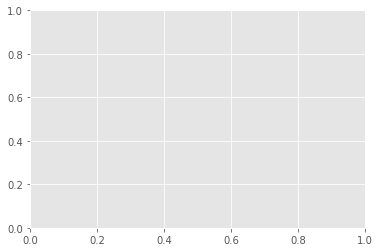

In [9]:
# validation set
predictions = model.predict(val_X, batch_size=batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(val_Y, axis= 1)

print(classification_report(actuals, predictions))

# Plot the losses and accuracies
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"],
label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"],
label= "val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"],
label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"],
label= "val_acc")
plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
#plt.savefig("plot.jpg")
plt.show()

## Test Set (Out of Sample)

In [ ]:
# out of sample data
predictions = model.predict(test_X, batch_size=batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

print(classification_report(actuals, predictions))

# Save the model

In [ ]:
model.save('outputs/model_01.h5')